In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gmt.objects import Interval,Ball, Cube
from gmt.plot import new_plot

In [8]:
def get_random_points(m,mu,sigma):
    X = np.random.multivariate_normal(np.array(mu),cov=np.array([[sigma,0],[0,sigma]]), size=m)
    X = np.array([x for x in X if np.max(np.absolute(x-np.array([.5,.5])))<=.45])
    return X
    
def random_epsilon(m=3,d=2,epsilon=.01):
    return [np.random.uniform(low=0.0, high=epsilon, size=d) for _ in range(m)]


def default(ax):
    ax.set_xlim([-.01,1.01])
    ax.set_ylim([-.01,1.01])
    ax.set_aspect("equal")
    ax.axis("off")
    return ax

def plot_cubes(cubes,ax, **kwargs):
    for Q in cubes:
        Q.plot(ax, **kwargs)


    

In [6]:

#Returns interval of generation n containing point
def covering_interval(x,n):
    a = (x * (2**n) // 1) * (2**(-n))
    return Interval([a,a+2**(-n)])

#Returns intervals of generation n covering set of points
def get_interval_cover(X,n):
    return {covering_interval(x,n) for x in X}

#Returns cube of generation n containing point   
def covering_cube(x,n):
    return Cube([covering_interval(coordinate,n) for coordinate in x])

#Returns cube of generation n covering set of points
def get_cube_cover(X,n):
    return {covering_cube(x,n) for x in X}

get_cube_cover([[.1,.1], [.6,.6]],3)

{Cube[[0.0, 0.125], [0.0, 0.125]], Cube[[0.5, 0.625], [0.5, 0.625]]}

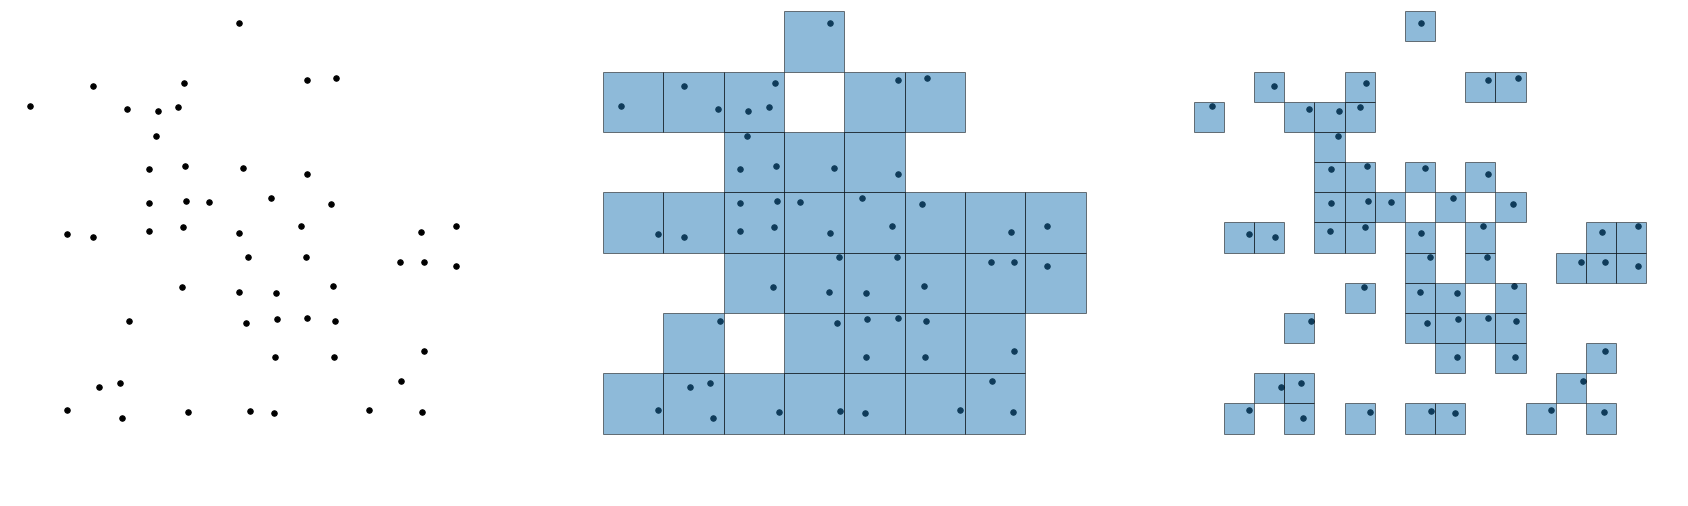

In [10]:
fig, ax = plt.subplots(1,3, figsize = (30,10))
for a in ax:
    a=default(a)
    
X = get_random_points(100, [.5,.5], .1)

n=4
cubes = get_cube_cover(X,n)

centers = np.array([Q.x for Q in cubes])

off_centers = centers + .4*2**(-n)*np.random.rand(*centers.shape)

for a in ax:
    a.scatter(off_centers[:,0],off_centers[:,1], c="black", s=30)
    

plot_cubes(cubes, ax=ax[2], alpha=.5, edgecolor="black")
plot_cubes(get_cube_cover(X,n-1), ax=ax[1], alpha=.5, edgecolor="black")


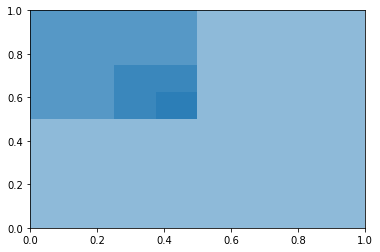

In [11]:
def get_tree_of_cubes(n,d=None,X=None):
    if type(X) is np.ndarray:
        d=X.shape[1]
    else:
        assert d>=1 and type(d) is int, "Must specify an integer dimension d unless a list of points X is provided"

    tree = dict()
    unit_square = Cube([[0,1] for _ in range(d)])
    
    for i in range(n+1):
        if type(X) is np.ndarray:
            tree[i] = get_cube_cover(X,i)
            
        else:
            tree[i] = unit_square.descendants(i)
    return tree


    

g = get_tree_of_cubes(3,2,X=np.array([[.4,.5]]))

fig, ax = plt.subplots()
for i in g:
    plot_cubes(list(g[i]), ax=ax, alpha=.5)

In [12]:

def frostmann_measure(X,n,s):
    
    d=X.shape[1]
    
    unit_cube = Cube([[0,1] for _ in range(d)])
    
    
    
    tree = get_tree_of_cubes(n,d)
    
    
    
    

    bottom_cubes_over_X = get_cube_cover(X,n)
    
    density=dict()
    mu = dict()
    for Q in tree[n]:
        if Q in bottom_cubes_over_X:
            density[Q]=1
            mu[Q] = Q.len**s
        else:
            density[Q]=0
            mu[Q]=0
    
    for i in reversed(range(n)):
        for Q in tree[i]:
            mu[Q] = sum([mu[R] for R in Q.children()])
            if mu[Q] > Q.len**s:
                density[Q] = (Q.len**s)/mu[Q]
                mu[Q] = Q.len**s
            else:
                density[Q] = 1
    
    f={unit_cube:2**(-n)}
    for i in range(n):
        for Q in tree[i]:
            for R in Q.children():
                f[R] = f[Q]*density[R]
                
    return {Q:f[Q] for Q in tree[n]}



                

    
        




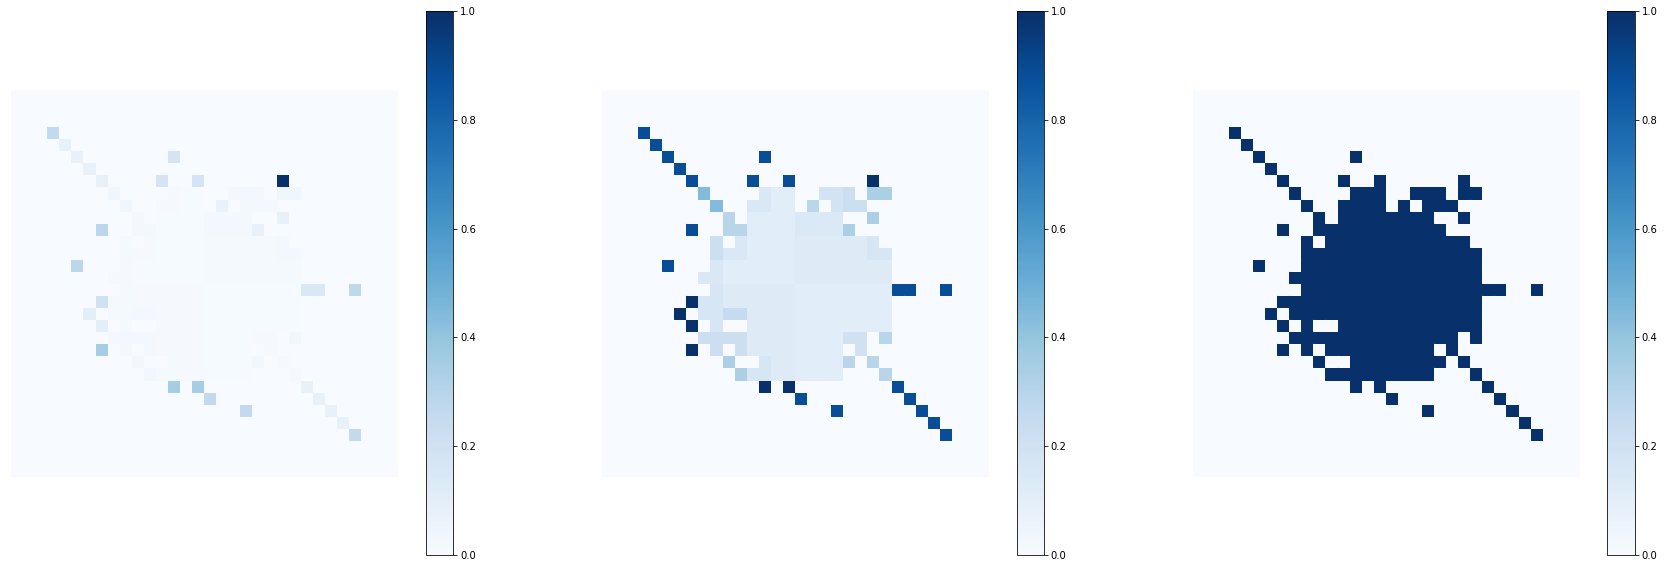

In [14]:
from  matplotlib import colorbar

X = get_random_points(1000,[.5,.5],.01)

X = np.concatenate([X,np.array([[t,1-t] for t in np.arange(.1,.9,.01)])])

fig, axes = plt.subplots(1,3, figsize=(30,10))

for ax in axes:
    default(ax)
    
    
cmap=plt.cm.Blues

L = [.1,1,2]

for i, ax in enumerate(axes):
    
    f = frostmann_measure(X,5,L[i]) 

    cax, _ = colorbar.make_axes(ax) 
    
    cb = colorbar.ColorbarBase(cax, cmap=cmap)

    max_density = max(f.values())

    for Q in f:
        Q.plot( ax=ax, color=cmap(f[Q]/max_density))
    
